In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from utils import *
from models import *

import numpy as np

from tqdm import tqdm
import random

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

/home/cs3964_group1/.conda/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:1


(177, 284, 3)


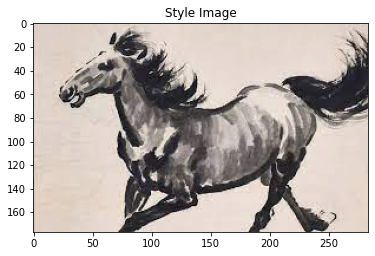

In [2]:
style_path = "pic/img_style/s7.jpg"
style_img = read_image(style_path).to(device)
imshow(style_img, title='Style Image')

In [3]:
vgg16 = models.vgg16(pretrained=True)
vgg16 = VGG(vgg16.features[:23]).to(device).eval()

/home/cs3964_group1/.conda/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cs3964_group1/.conda/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
def ConvLayer(in_channels, out_channels, kernel_size=3, stride=1, 
    upsample=None, instance_norm=True, relu=True):
    layers = []
    if upsample:
        layers.append(nn.Upsample(mode='nearest', scale_factor=upsample))
    layers.append(nn.ReflectionPad2d(kernel_size // 2))
    layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride))
    if instance_norm:
        layers.append(nn.InstanceNorm2d(out_channels))
    if relu:
        layers.append(nn.ReLU())
    return layers

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv = nn.Sequential(
            *ConvLayer(channels, channels, kernel_size=3, stride=1), 
            *ConvLayer(channels, channels, kernel_size=3, stride=1, relu=False)
        )

    def forward(self, x):
        return self.conv(x) + x

In [5]:
class TransformNet(nn.Module):
    def __init__(self, base=32):
        super(TransformNet, self).__init__()
        self.downsampling = nn.Sequential(
            *ConvLayer(3, base, kernel_size=9), 
            *ConvLayer(base, base*2, kernel_size=3, stride=2), 
            *ConvLayer(base*2, base*4, kernel_size=3, stride=2), 
        )
        self.residuals = nn.Sequential(*[ResidualBlock(base*4) for i in range(5)])
        self.upsampling = nn.Sequential(
            *ConvLayer(base*4, base*2, kernel_size=3, upsample=2),
            *ConvLayer(base*2, base, kernel_size=3, upsample=2),
            *ConvLayer(base, 3, kernel_size=9, instance_norm=False, relu=False),
        )
    
    def forward(self, X):
        y = self.downsampling(X)
        y = self.residuals(y)
        y = self.upsampling(y)
        return y

In [6]:
def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram

In [7]:
batch_size = 4
width = 256

data_transform = transforms.Compose([
    transforms.Resize(width), 
    transforms.CenterCrop(width), 
    transforms.ToTensor(), 
    tensor_normalizer, 
])

dataset = torchvision.datasets.ImageFolder('coco', transform=data_transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
print(dataset)

Dataset ImageFolder
    Number of datapoints: 128
    Root location: coco
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(256, 256))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [8]:
style_features = vgg16(style_img)
style_grams = [gram_matrix(x) for x in style_features]
style_grams = [x.detach() for x in style_grams]
[x.shape for x in style_grams]

[torch.Size([1, 64, 64]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 256, 256]),
 torch.Size([1, 512, 512])]

In [9]:
def tensor_to_array(tensor):
    x = tensor.cpu().detach().numpy()
    x = (x*255).clip(0, 255).transpose(0, 2, 3, 1).astype(np.uint8)
    return x

def save_debug_image(style_images, content_images, transformed_images, filename):
    style_image = Image.fromarray(recover_image(style_images))
    content_images = [recover_image(x) for x in content_images]
    transformed_images = [recover_image(x) for x in transformed_images]
    
    new_im = Image.new('RGB', (style_image.size[0] + (width + 5) * 4, max(style_image.size[1], width*2 + 5)))
    new_im.paste(style_image, (0,0))
    
    x = style_image.size[0] + 5
    for i, (a, b) in enumerate(zip(content_images, transformed_images)):
        new_im.paste(Image.fromarray(a), (x + (width + 5) * i, 0))
        new_im.paste(Image.fromarray(b), (x + (width + 5) * i, width + 5))
    
    new_im.save(filename)

In [10]:
transform_net = TransformNet(32).to(device)

In [11]:
verbose_batch = 400
style_weight = 2e5
content_weight = 1
tv_weight = 1e-6
epoch_num = 50

In [12]:
optimizer = optim.Adam(transform_net.parameters(), 1e-3)
transform_net.train()

content_loss_list=[]
style_loss_list=[]
loss_list=[]

n_batch = len(data_loader)

for epoch in range(epoch_num):
    print('Epoch: {}'.format(epoch+1))
    smooth_content_loss = Smooth()
    smooth_style_loss = Smooth()
    smooth_tv_loss = Smooth()
    smooth_loss = Smooth()
    with tqdm(enumerate(data_loader), total=n_batch) as pbar:
        for batch, (content_images, _) in pbar:
            optimizer.zero_grad()

            # 使用风格模型预测风格迁移图像
            content_images = content_images.to(device)
            transformed_images = transform_net(content_images)
            transformed_images = transformed_images.clamp(-3, 3)

            # 使用 vgg16 计算特征
            content_features = vgg16(content_images)
            transformed_features = vgg16(transformed_images)

            # content loss
            content_loss = content_weight * F.mse_loss(transformed_features[1], content_features[1])
            
            # total variation loss
            y = transformed_images
            tv_loss = tv_weight * (torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) + 
            torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])))

            # style loss
            style_loss = 0.
            transformed_grams = [gram_matrix(x) for x in transformed_features]
            for transformed_gram, style_gram in zip(transformed_grams, style_grams):
                style_loss += style_weight * F.mse_loss(transformed_gram, 
                                                        style_gram.expand_as(transformed_gram))

            # 加起来
            loss = style_loss + content_loss + tv_loss

            loss.backward()
            optimizer.step()

            smooth_content_loss += content_loss.item()
            smooth_style_loss += style_loss.item()
            smooth_tv_loss += tv_loss.item()
            smooth_loss += loss.item()

            content_loss_list.append(smooth_content_loss)
            style_loss_list.append(smooth_style_loss)
            loss_list.append(smooth_loss)
            
            s = f'Content: {smooth_content_loss:.2f} '
            s += f'Style: {smooth_style_loss:.2f} '
            s += f'TV: {smooth_tv_loss:.4f} '
            s += f'Loss: {smooth_loss:.2f}'
            if batch % verbose_batch == 0:
                # s = '\n' + s
                save_debug_image(style_img, content_images, transformed_images, f"debug/s2_{epoch}_{batch}.jpg")
            
            pbar.set_description(s)
    torch.save(transform_net.state_dict(), 'transform_net.pth')

Epoch: 1


  0%|          | 0/32 [00:00<?, ?it/s]

Content: 8.54 Style: 105.07 TV: 0.2020 Loss: 113.81: 100%|██████████| 32/32 [00:04<00:00,  7.32it/s]


Epoch: 2


Content: 5.45 Style: 71.25 TV: 0.0365 Loss: 76.74: 100%|██████████| 32/32 [00:04<00:00,  7.66it/s]


Epoch: 3


Content: 7.72 Style: 57.23 TV: 0.0900 Loss: 65.04: 100%|██████████| 32/32 [00:04<00:00,  7.63it/s]


Epoch: 4


Content: 7.41 Style: 36.27 TV: 0.1557 Loss: 43.84: 100%|██████████| 32/32 [00:04<00:00,  7.64it/s]


Epoch: 5


Content: 9.51 Style: 22.24 TV: 0.2060 Loss: 31.96: 100%|██████████| 32/32 [00:04<00:00,  7.61it/s]


Epoch: 6


Content: 8.45 Style: 17.18 TV: 0.2472 Loss: 25.88: 100%|██████████| 32/32 [00:04<00:00,  7.61it/s]


Epoch: 7


Content: 8.51 Style: 13.43 TV: 0.2763 Loss: 22.22: 100%|██████████| 32/32 [00:04<00:00,  7.25it/s]


Epoch: 8


Content: 7.55 Style: 10.90 TV: 0.2735 Loss: 18.72: 100%|██████████| 32/32 [00:04<00:00,  7.44it/s]


Epoch: 9


Content: 8.69 Style: 8.94 TV: 0.3016 Loss: 17.94: 100%|██████████| 32/32 [00:04<00:00,  7.45it/s]


Epoch: 10


Content: 8.55 Style: 7.91 TV: 0.3105 Loss: 16.77: 100%|██████████| 32/32 [00:04<00:00,  7.42it/s]


Epoch: 11


Content: 8.88 Style: 7.23 TV: 0.3276 Loss: 16.45: 100%|██████████| 32/32 [00:04<00:00,  7.39it/s]


Epoch: 12


Content: 7.60 Style: 6.99 TV: 0.3093 Loss: 14.90: 100%|██████████| 32/32 [00:04<00:00,  7.36it/s]


Epoch: 13


Content: 8.33 Style: 6.22 TV: 0.3233 Loss: 14.87: 100%|██████████| 32/32 [00:04<00:00,  7.20it/s]


Epoch: 14


Content: 7.13 Style: 5.54 TV: 0.3287 Loss: 13.00: 100%|██████████| 32/32 [00:04<00:00,  7.20it/s]


Epoch: 15


Content: 7.63 Style: 5.18 TV: 0.3186 Loss: 13.12: 100%|██████████| 32/32 [00:04<00:00,  7.17it/s]


Epoch: 16


Content: 8.00 Style: 5.08 TV: 0.3226 Loss: 13.41: 100%|██████████| 32/32 [00:04<00:00,  7.19it/s]


Epoch: 17


Content: 7.80 Style: 4.64 TV: 0.3201 Loss: 12.76: 100%|██████████| 32/32 [00:04<00:00,  7.16it/s]


Epoch: 18


Content: 8.54 Style: 4.63 TV: 0.3357 Loss: 13.50: 100%|██████████| 32/32 [00:04<00:00,  7.11it/s]


Epoch: 19


Content: 7.05 Style: 4.45 TV: 0.3247 Loss: 11.83: 100%|██████████| 32/32 [00:04<00:00,  7.06it/s]


Epoch: 20


Content: 7.25 Style: 4.24 TV: 0.3332 Loss: 11.82: 100%|██████████| 32/32 [00:04<00:00,  7.09it/s]


Epoch: 21


Content: 7.99 Style: 3.97 TV: 0.3320 Loss: 12.30: 100%|██████████| 32/32 [00:04<00:00,  7.00it/s]


Epoch: 22


Content: 7.07 Style: 3.79 TV: 0.3258 Loss: 11.19: 100%|██████████| 32/32 [00:04<00:00,  7.04it/s]


Epoch: 23


Content: 7.64 Style: 3.41 TV: 0.3350 Loss: 11.38: 100%|██████████| 32/32 [00:04<00:00,  7.03it/s]


Epoch: 24


Content: 7.67 Style: 3.44 TV: 0.3280 Loss: 11.43: 100%|██████████| 32/32 [00:04<00:00,  7.09it/s]


Epoch: 25


Content: 6.91 Style: 3.27 TV: 0.3307 Loss: 10.51: 100%|██████████| 32/32 [00:04<00:00,  6.94it/s]


Epoch: 26


Content: 7.33 Style: 3.38 TV: 0.3289 Loss: 11.04: 100%|██████████| 32/32 [00:04<00:00,  7.09it/s]


Epoch: 27


Content: 7.17 Style: 3.22 TV: 0.3283 Loss: 10.72: 100%|██████████| 32/32 [00:04<00:00,  7.18it/s]


Epoch: 28


Content: 7.41 Style: 3.25 TV: 0.3357 Loss: 10.99: 100%|██████████| 32/32 [00:04<00:00,  7.05it/s]


Epoch: 29


Content: 7.04 Style: 2.99 TV: 0.3242 Loss: 10.35: 100%|██████████| 32/32 [00:04<00:00,  7.08it/s]


Epoch: 30


Content: 6.99 Style: 3.00 TV: 0.3233 Loss: 10.31: 100%|██████████| 32/32 [00:04<00:00,  7.12it/s]


Epoch: 31


Content: 7.18 Style: 2.72 TV: 0.3371 Loss: 10.24: 100%|██████████| 32/32 [00:04<00:00,  7.06it/s]


Epoch: 32


Content: 7.44 Style: 3.08 TV: 0.3215 Loss: 10.84: 100%|██████████| 32/32 [00:04<00:00,  7.08it/s]


Epoch: 33


Content: 7.03 Style: 2.67 TV: 0.3357 Loss: 10.04: 100%|██████████| 32/32 [00:04<00:00,  7.08it/s]


Epoch: 34


Content: 8.15 Style: 2.63 TV: 0.3345 Loss: 11.11: 100%|██████████| 32/32 [00:04<00:00,  7.01it/s]


Epoch: 35


Content: 7.52 Style: 2.48 TV: 0.3315 Loss: 10.33: 100%|██████████| 32/32 [00:04<00:00,  6.99it/s]


Epoch: 36


Content: 6.29 Style: 2.52 TV: 0.3307 Loss: 9.15: 100%|██████████| 32/32 [00:04<00:00,  7.16it/s]


Epoch: 37


Content: 6.94 Style: 2.49 TV: 0.3308 Loss: 9.76: 100%|██████████| 32/32 [00:04<00:00,  7.24it/s]


Epoch: 38


Content: 7.50 Style: 2.55 TV: 0.3301 Loss: 10.38: 100%|██████████| 32/32 [00:04<00:00,  7.09it/s]


Epoch: 39


Content: 6.34 Style: 2.28 TV: 0.3309 Loss: 8.95: 100%|██████████| 32/32 [00:04<00:00,  7.07it/s]


Epoch: 40


Content: 5.82 Style: 2.45 TV: 0.3187 Loss: 8.60: 100%|██████████| 32/32 [00:04<00:00,  7.08it/s]


Epoch: 41


Content: 6.56 Style: 2.40 TV: 0.3225 Loss: 9.29: 100%|██████████| 32/32 [00:04<00:00,  7.05it/s]


Epoch: 42


Content: 6.83 Style: 2.39 TV: 0.3338 Loss: 9.56: 100%|██████████| 32/32 [00:04<00:00,  7.05it/s]


Epoch: 43


Content: 7.43 Style: 2.39 TV: 0.3317 Loss: 10.16: 100%|██████████| 32/32 [00:04<00:00,  7.07it/s]


Epoch: 44


Content: 6.08 Style: 2.47 TV: 0.3202 Loss: 8.87: 100%|██████████| 32/32 [00:04<00:00,  7.09it/s]


Epoch: 45


Content: 6.32 Style: 2.33 TV: 0.3239 Loss: 8.98: 100%|██████████| 32/32 [00:04<00:00,  7.08it/s]


Epoch: 46


Content: 5.64 Style: 2.25 TV: 0.3201 Loss: 8.21: 100%|██████████| 32/32 [00:04<00:00,  7.14it/s]


Epoch: 47


Content: 6.70 Style: 2.07 TV: 0.3301 Loss: 9.10: 100%|██████████| 32/32 [00:04<00:00,  7.05it/s]


Epoch: 48


Content: 6.79 Style: 2.15 TV: 0.3217 Loss: 9.26: 100%|██████████| 32/32 [00:04<00:00,  7.07it/s]


Epoch: 49


Content: 5.91 Style: 2.25 TV: 0.3264 Loss: 8.49: 100%|██████████| 32/32 [00:04<00:00,  7.10it/s]


Epoch: 50


Content: 6.31 Style: 2.17 TV: 0.3279 Loss: 8.81: 100%|██████████| 32/32 [00:04<00:00,  7.19it/s]


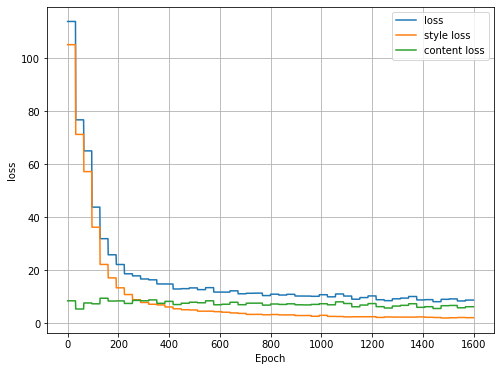

In [13]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 6))
plt.plot(loss_list, label='loss')
plt.plot(style_loss_list, label='style loss')
plt.plot(content_loss_list, label='content loss')


plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()

plt.grid(True)
plt.show()

(177, 284, 3)
(256, 256, 3)
(256, 256, 3)


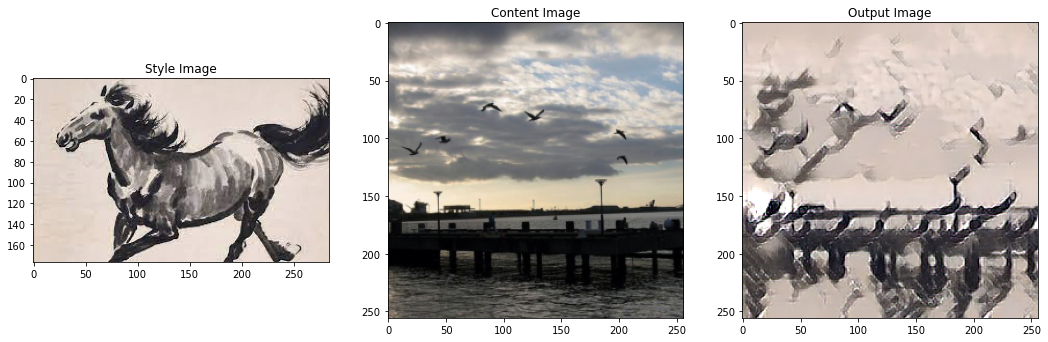

In [29]:
content_img = random.choice(dataset)[0].unsqueeze(0).to(device)
output_img = transform_net(content_img)

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
imshow(style_img, title='Style Image')

plt.subplot(1, 3, 2)
imshow(content_img, title='Content Image')

plt.subplot(1, 3, 3)
imshow(output_img.detach(), title='Output Image')